In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm

os.chdir('..')
from models.model_vision import BaseVision
from utils import CharsetMapper, get_data_loader, Config

charset = CharsetMapper('data/charset_36.txt')

def visualize_embeddings(model_baseline, model_conclr, data_loader, device, num_samples=20000):
# def visualize_embeddings(model, data_loader, device, num_samples=1000):
    # model.eval()
    model_baseline.eval()
    model_conclr.eval()
    # embeddings = []
    embeddings_baseline = []
    embeddings_conclr = []
    character_labels = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            # features = model.backbone(images.to(device))
            # attn_vecs, _ = model.attention(features)
            # embeddings.append(attn_vecs.view(-1, attn_vecs.size(-1)).cpu())

            features_baseline = model_baseline.backbone(images.to(device))
            attn_vecs_baseline, _ = model_conclr.attention(features_baseline)
            # embeddings_baseline.append(attn_vecs_baseline.view(-1, attn_vecs_baseline.size(-1)).cpu())

            features_conclr = model_conclr.backbone(images.to(device))
            attn_vecs_conclr, _ = model_conclr.attention(features_conclr)
            # embeddings_conclr.append(attn_vecs_conclr.view(-1, attn_vecs_conclr.size(-1)).cpu())

            for i in range(len(labels)):
                text = charset.get_text(labels[i], padding=False)
                for j in range(len(text)):
                    if text[j] in 'ghypf':
                        embeddings_baseline.append(attn_vecs_baseline[i][j].cpu())
                        embeddings_conclr.append(attn_vecs_conclr[i][j].cpu())
                        character_labels.append(text[j])

            # labels.append(labels_.flatten().cpu())
            if len(character_labels) >= num_samples:
                break
    # embeddings = torch.cat(embeddings, dim=0)
    # embeddings = embeddings[:num_samples]

    embeddings_baseline = torch.stack(embeddings_baseline)
    embeddings_conclr = torch.stack(embeddings_conclr)
    
    # embeddings_baseline = embeddings_baseline[:num_samples]
    # embeddings_conclr = embeddings_conclr[:num_samples]

    # labels = torch.cat(labels, dim=0)
    # labels = labels[:num_samples]

    # tsne = TSNE(n_components=2, random_state=0)
    # embeddings = tsne.fit_transform(embeddings.numpy())
    # return embeddings, labels

    tsne_baseline = TSNE(n_components=2, random_state=0)
    tsne_conclr = TSNE(n_components=2, random_state=0)
    embeddings_baseline = tsne_baseline.fit_transform(embeddings_baseline.cpu().numpy())
    embeddings_conclr = tsne_conclr.fit_transform(embeddings_conclr.cpu().numpy())
    return embeddings_baseline, embeddings_conclr, character_labels

def plot_embeddings(embeddings, labels):
    char_points = {
        'g': np.array([]),
        'h': np.array([]),
        'y': np.array([]),
        'p': np.array([]),
        'f': np.array([]),
    }
    for i in range(embeddings.shape[0]):
        c = labels[i]
        x, y = embeddings[i]
        char_points[c] = np.vstack([char_points[c], np.array([x, y])]) if char_points[c].size else np.array([[x, y]])
    plt.figure(figsize=(10, 10))
    for c, points in char_points.items():
        plt.scatter(points[:, 0], points[:, 1], label=c, s=10)
    plt.legend()
    plt.show()


In [11]:
config = Config('configs/config.yaml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
baseline_checkpoint = 'checkpoints/best-pretrain-vision-model.pth'
conclr_checkpoint = 'runs/ConCLR_Adam_1e-4_Tmax16000/checkpoints/step_18000_eval_19.213118076324463_acc_0.8447265625.pth'
model_baseline = BaseVision(config).to(device)
model_conclr = BaseVision(config).to(device)

model_conclr.load_state_dict(torch.load(conclr_checkpoint))

data_loader = get_data_loader(config.dataset_root, config.dataset_test_labels, batch_size=256, conaug=False)
# embeddings_baseline, labels_baseline = visualize_embeddings(model_baseline, data_loader, device)
# embeddings_conclr, labels_conclr = visualize_embeddings(model_conclr, data_loader, device)
embeddings_baseline, embeddings_conclr, labels = visualize_embeddings(model_baseline, model_conclr, data_loader, device)
print(embeddings_baseline.shape, embeddings_conclr.shape, len(labels))


  2%|▏         | 85/3410 [08:03<5:15:06,  5.69s/it]
d:\Anaconda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\Anaconda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\Anaconda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\Anaconda\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(20133, 2) (20133, 2) 20133


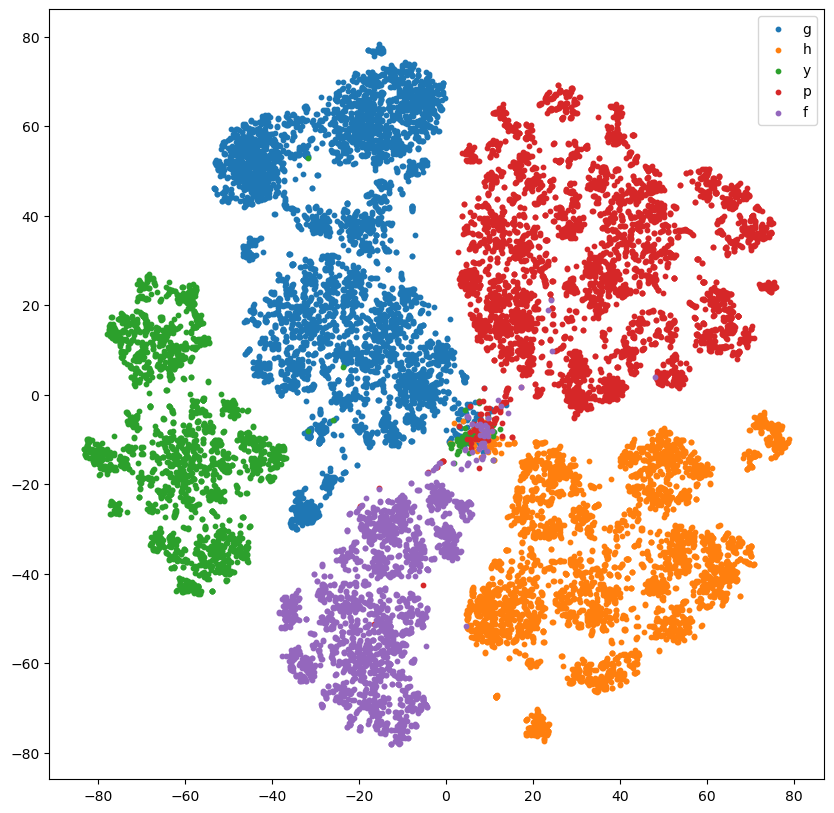

In [12]:
plot_embeddings(embeddings_baseline, labels)

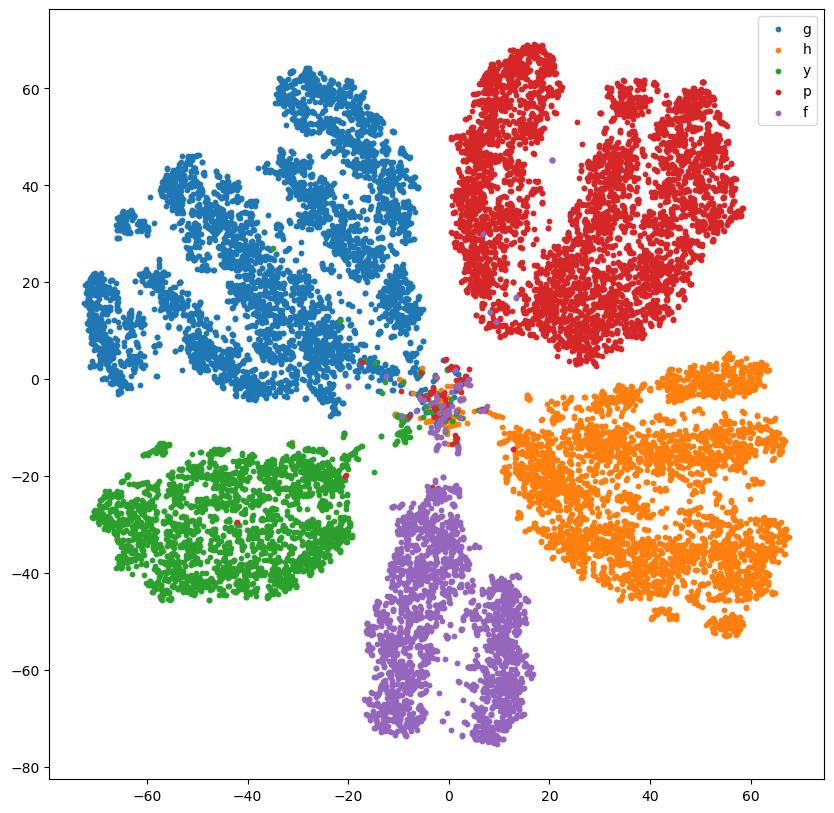

In [13]:
plot_embeddings(embeddings_conclr, labels)